# Coders for hability - proposal excercise

As a part of the propsoal, I was asked to plot a flux-time curve for XO-3b from the IRAC Data Challenge 2015. The data set contains 10 archival Spitzer observations of XO-3b during eclipse. 

Each of the ten observations represents a separate visit to XO-3 b and consists of 2 AORs, a 30-min pre-AOR (to accomodate short-term pointing drift) and a ~8.5 hour staring mode AOR with 2s exposure times, observed in sub-array mode with IRAC Channel 2 (4.5 microns).

I have take the first visit to X0-3 b and created a demo pipeline to create the flux-time plot for the same.



## The dataset description

The data is presented in two forms: (1) tables of derived photometry and centroids, and (2) the usual FITS format Basic Calibrated Data (BCD) images. 

I have used the BCD images and passed thru the demo data reduction pipeline. 
Each visit has 233-exposure, 8.5 hour AOR that contains the secondary eclipse. Each exposure produced a FITS format image file, containing a cube of 64 32×32 pixel images taken 2 seconds apart with the source in the subarray field-of-view on the 4.5 μm array.

## Demo data reduction pipeline

The steps involved in the process are:
* Reading the FITS files using `astropy`
* Background subtraction for each file
* Locating the centroid position of the center pixel
* Apearture photometry using `photutils` with 2.25-pixel radius circular aperture and a 5 pixel background annulus

__________

### Getting to know the data


I downloaded the IRAC dataset from the Data Challenge 2015 for the 2nd epoch. The epoch had 233 exposures and each exposure produced a FITS file containing an image cube. The image cube has 64 images stacked on top of each other, each 32x32. 

In [1]:
# Finding the number of files
file_list = glob("bcd/*bcd*")
print len(file_list)
print file_list[0]

233
bcd/SPITZER_I2_46471424_0000_0000_2_bcd.fits


In [2]:
# Each FITS has 64, 32by32 image files
hdu = fits.open(file_list[0])
print hdu.info()
print
print hdu[0].data.shape

Filename: bcd/SPITZER_I2_46471424_0000_0000_2_bcd.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     669   (32, 32, 64)   float32   
None

(64, 32, 32)


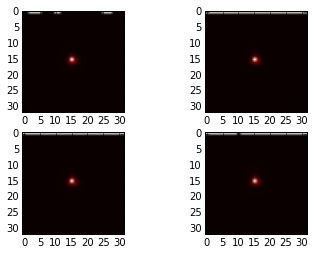

In [3]:
#Plotting 4 images

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.imshow(hdu[0].data[0], cmap="hot")

ax2 = fig.add_subplot(222)
ax2.imshow(hdu[0].data[10], cmap="hot")

ax3 = fig.add_subplot(223)
ax3.imshow(hdu[0].data[20], cmap="hot")

ax4 = fig.add_subplot(224)
ax4.imshow(hdu[0].data[30], cmap="hot")


___________
## Demo excercise


#### Imports

In [4]:
#reading the files
from astropy.io import fits

#traversing the files
from glob import glob

#general utilites
import numpy as np
from collections import defaultdict

#for photometry
from photutils import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import detect_sources
from scipy.ndimage import binary_dilation
from photutils import daofind
from photutils import CircularAperture
from photutils import CircularAnnulus
from astropy.table import hstack

### Pre-processing

#### Replacing NaNs with median

In [5]:
def replace_nan(hdu_data):
    """
    Takes the time series of each pixel and replaces the `nan` values with the median
    value. 
    Returns the updated hdu file. 
    """
    pixels = defaultdict(list)
    for pic in hdu_data:
        for ci, row in enumerate(pic):
            for cj, col in enumerate(row):
                pixels[(ci, cj)].append(col)

    for key, value in pixels.iteritems():
        med = np.median([i for i in value if not np.isnan(i)])
        for counter,pixel in enumerate(value):
            if np.isnan(pixel):
                hdu_data[counter][key[0]][key[1]] = med
    return hdu_data


#### Background subtraction

In [6]:
def background_subtraction(hdu):
    """
    Takes in the 63 image cube and uses sigma cliping to mask the source. 
    Pixels that are above or below a specified sigma level from the median
    are discarded and the statistics are recalculated, repeating till convergence.
    
    Returns the mean, median, std of for each frame in the image cube
    """
    vals={}
    for counter, pic in enumerate(hdu):
        mean, median, std = sigma_clipped_stats(pic, sigma=3.0, iters=15)
        threshold = median + (std * 2.)
        segm_img = detect_sources(pic, threshold, npixels=5)
        mask = segm_img.data.astype(np.bool)
        mean, median, std = sigma_clipped_stats(pic, sigma=3.0, mask=mask, iters=15)
        vals[counter] = (mean, median, std)
    return vals

#### Finding the centroid of the source

In [7]:
def locate_centroid(hdu, vals):
    """
    Uses the daofind algorithm to detech the sources and determine their centroids. 
    
    Returns the mean values of x and y coordinates of the sources. These values are
    used to find the flux later using a circular . 
    """
    centroids = {}
    xcord = []
    ycord = []
    for counter, pic in enumerate(hdu):
        sources = daofind(pic - vals[counter][1], fwhm=3.0, threshold=5.*vals[counter][2])
        xcord.extend(list(sources['xcentroid'].data))
        ycord.extend(list(sources['ycentroid'].data))
    xmean, xmedian, xstd = sigma_clipped_stats(xcord, sigma=1, iters=25)
    ymean, ymedian, ystd = sigma_clipped_stats(ycord, sigma=1, iters=25)
    return (xmean, ymean)

#### Finding the flux

In [8]:
def determine_flux(hdu, xcord, ycord):
    """
    We use a circular annulus to find the local background level around the
    source with a circular annulus of inside radius of 6 and outside radius of 8.
    The mean backgound is calculated and subtracted from the sources circular
    apperture to find the true flux
    
    Returns fluxes for each image cube
    """
    fluxes = []
    for counter, pic in enumerate(hdu):
        positions = (xcord, ycord)
        apertures = CircularAperture(positions, r=3)
        annulus_apertures = CircularAnnulus(positions, r_in=6., r_out=8.)
        rawflux_table = aperture_photometry(pic, apertures)
        bkgflux_table = aperture_photometry(pic, annulus_apertures)
        phot_table = hstack([rawflux_table, bkgflux_table], table_names=['raw', 'bkg'])
        bkg_mean = phot_table['aperture_sum_bkg'] / annulus_apertures.area()
        bkg_sum = bkg_mean * apertures.area()
        flux = phot_table['aperture_sum_raw'] - bkg_sum
        fluxes.extend(flux.data)
    return fluxes

#### The main loop

In [9]:
# Here, we loop over all the 233 FITS files and for each file, we find the flux and add it to 
# the master flux list - all_fluxes
all_fluxes=[]
for fit in sorted(glob("bcd/*bcd*")):
    print "Working on...", fit
    hdu = fits.open(fit)
    hdu[0].data = hdu[0].data[1:-1]
    _ = replace_nan(hdu[0].data)
    red = background_subtraction(_)
    centrs = locate_centroid(hdu[0].data, red)
    all_fluxes.extend(determine_flux(hdu[0].data, centrs[0], centrs[1]))

Working on... bcd/SPITZER_I2_46471424_0000_0000_2_bcd.fits
Working on... bcd/SPITZER_I2_46471424_0001_0000_2_bcd.fits
...
Working on... bcd/SPITZER_I2_46471424_0232_0000_2_bcd.fits


### Plotting


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
#plotting the flux data
plt.scatter(range(len(all_fluxes)), all_fluxes)

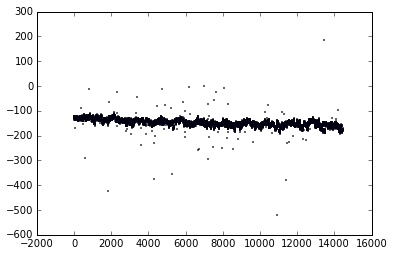

In [12]:
plt.scatter(range(len(all_fluxes)), all_fluxes, s=0.5)

In [13]:
binned=[]
for i in range(0, len(all_fluxes), 5):
     binned.append(np.mean(all_fluxes[i:i+5]))

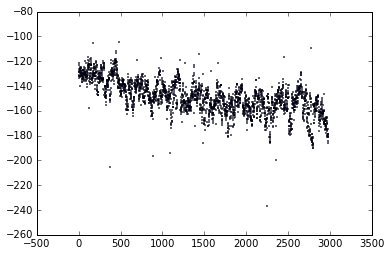

In [14]:
plt.scatter(range(len(binned)), binned, s=0.5)

We plot the flux as obtained by the aperture photometry above. 